# DTM (Figures 1, 2 and Tables 1, 2)

This is adapted (partially) from https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/dtm_example.ipynb


In [1]:
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
import numpy as np
import pandas as pd

%matplotlib inline

train = True

import json
import re

from gensim.parsing.preprocessing import STOPWORDS

# script author defined stop words
STOPWORDS_ = ['rt', '', 'httpst', 'amp']

# load the tweets
documents = []
time_seq = []
weeknum = ''
ds_fact = 3
with open('../data/c_twitter.json') as f_in:
    for i, l in enumerate(f_in):
        if (i % ds_fact == 0):
            index =+ 1
            c_twt = json.loads(l)

            # remove punctuation and stopwords for this analysis
            words = re.sub(r'[^a-zA-Z\s]', '', c_twt['text'])
            words = words.split()
            words = [w for w in words if (w not in STOPWORDS and w not in STOPWORDS_)]
            words = [bytes(w, 'utf-8') for w in words]

            # c_twt: {'weeknum': str, 'c_text': str, 'tags': [str]}
            documents.append(words)

            if weeknum != c_twt['weeknum']:
                time_seq.append(i // ds_fact)
                weeknum = c_twt['weeknum']
            
time_seq.append(len(documents))
y = time_seq[1:] + [0]
x = time_seq[:]
time_seq = []
for x, y in zip(x, y):
    time_seq.append(y - x)

del time_seq[-1]
time_seq

[7632,
 8618,
 21301,
 10714,
 7590,
 2446,
 7872,
 8332,
 7270,
 6251,
 2555,
 11368,
 7188,
 16573,
 13830,
 31953,
 11968,
 9854,
 7664,
 7211]

In [2]:
from gensim.models import TfidfModel

dictionary = corpora.Dictionary(documents)
dictionary.filter_extremes(no_below=10, no_above=0.3, keep_n=100000)
corpus = [dictionary.doc2bow(doc) for doc in documents]

len(corpus)

208190

In [3]:
# tfidf = TfidfModel(corpus)
# corpus = tfidf[corpus]
corpus[0]

[(152, 1),
 (181, 1),
 (1212, 1),
 (2786, 1),
 (9757, 1),
 (12041, 1),
 (12401, 1),
 (12972, 1)]

# Train model (or load model from file)

In [4]:
if train:
    dtm_binary_path = '/high_spd_work/sm_w2v/tools/dtm/dtm/dtm'
    model = DtmModel(dtm_binary_path, corpus, time_seq, num_topics=10,
                     id2word=dictionary, initialize_lda=True, rng_seed=0)
    model.save('../models/dtm_example.model')
else:
    model = DtmModel.load('../models/dtm_example.model')

# Figure 1, 2 and Table 1, 2: Dynamic Topic Modeling

I'm proposing that in figures 1 and 2, we pick 2 topics from the Dynamic Topic Model, and describe the progression in time of these 2 topics with time series graphs, and tables 1 and 2 will be top 10 tables of these same topics over time


Topic ID's 8, 7 and 3 are all interesting

In [5]:
# This cell just gets the week nums (YYYY-WW)

def make_weeknums():
    # first  week is 2015-47
    week = 47
    year = 2015
    weeknums = []
    for i in range(len(model.time_slices)):
        weeknums.append(str(year) + '-' + str(week))
        week = week + 1

        if week > 53:
            year = year + 1
            week = 1
    
    return weeknums

weeknums = make_weeknums()

# Table 1: top 10 words associated with topic ID 3 over time

note how 'prep' is absent from top ten in the beginning, then increases over time

In [6]:
for t_index in range(len(model.time_slices)):
    print("--- time slice: ", t_index, "\n")
    print(pd.DataFrame(model.show_topic(topicid=9, time=t_index, topn=10), columns=['Probability', 'Word']))
    print()

--- time slice:  0 

   Probability         Word
0     0.125361          You
1     0.053233           Do
2     0.042645  Immediately
3     0.030081         Read
4     0.028556       spread
5     0.026624     symptoms
6     0.024364       Please
7     0.022583      dentist
8     0.021792         Test
9     0.021305         porn

--- time slice:  1 

   Probability             Word
0     0.135367              You
1     0.060020               Do
2     0.048579      Immediately
3     0.035626             Read
4     0.031385         symptoms
5     0.029296           Please
6     0.026617             Test
7     0.023979         AJEdinho
8     0.018696  dopeislandvines
9     0.018145           spread

--- time slice:  2 

   Probability             Word
0     0.142136              You
1     0.069340               Do
2     0.057399      Immediately
3     0.045064             Read
4     0.039558         symptoms
5     0.038226           Please
6     0.035342             Test
7     0.028043     

# Figure 1: key terms PrEP related

also seeing nancy reagan:
http://www.newyorker.com/news/daily-comment/hillary-clinton-nancy-reagan-and-aids

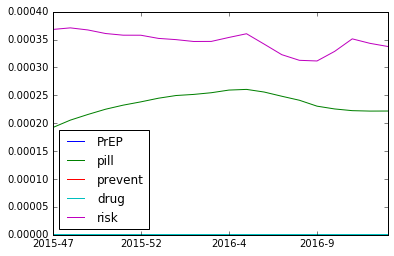

In [7]:
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=3, time=t_index, topn=1000)
        
    columns = ['PrEP', 'pill', 'prevent', 'drug', 'risk']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)
    
df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='')
fig = ax.get_figure()
fig.savefig('DTMfig1.pdf', format='pdf')

# Fig 2: Other PrEP related:
http://hub.jhu.edu/2016/02/08/first-hiv-positive-kidney-liver-transplants

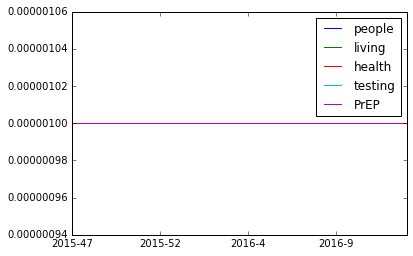

In [8]:
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=9, time=t_index, topn=1000)
        
    columns = ['people', 'living', 'health', 'testing', 'PrEP']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)
    
df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='')
fig = ax.get_figure()
fig.savefig('DTMfig2.pdf', format='pdf')

# Fig3: World AIDS Day related:


In [9]:
for t_index in range(len(model.time_slices)):
    print("--- time slice: ", t_index, "\n")
    print(pd.DataFrame(model.show_topic(topicid=0, time=t_index, topn=10), columns=['Probability', 'Word']))
    print()

--- time slice:  0 

   Probability      Word
0     0.095917   Charlie
1     0.056517     Sheen
2     0.039537    Sheens
3     0.013938       men
4     0.010675        To
5     0.007950  positive
6     0.007528       The
7     0.007066       His
8     0.006506    Status
9     0.006404       gay

--- time slice:  1 

   Probability      Word
0     0.082005   Charlie
1     0.049308     Sheen
2     0.031989    Sheens
3     0.016494       men
4     0.010661        To
5     0.008496       The
6     0.007929       gay
7     0.006992  positive
8     0.006689       His
9     0.006534    Status

--- time slice:  2 

   Probability     Word
0     0.067765  Charlie
1     0.042084    Sheen
2     0.024919   Sheens
3     0.020080      men
4     0.010186      gay
5     0.010112       To
6     0.008820      The
7     0.006398        N
8     0.006234      His
9     0.005994   Status

--- time slice:  3 

   Probability     Word
0     0.058867  Charlie
1     0.038717    Sheen
2     0.022687      men
3  

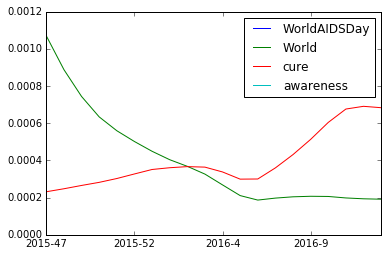

In [10]:
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=0, time=t_index, topn=1000)
        
    columns = ['WorldAIDSDay', 'World', 'cure', 'awareness']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)


df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='')
fig = ax.get_figure()
fig.savefig('DTMfig3.pdf', format='pdf')